# Matrix Factorization 및 유사도 함수
- Matrix Factorization : 행렬 분해
  - Latent Factor로 행렬 분해
  - 원본 데이터 -> User Latent Matrix (Random) X Item Latent Matrix (Random)
  - User Latent Matrix (Trained) X Item Latent Matrix (Trained) -> 예측 데이터  

## 행렬의 기본 원리

- regularization
  - 파라미터 적용을 줄이는 역학
  - L1 Norm : 파라미터의 절대값의 합, 일부 파라미터가 0(=비활성화)가 될 수 있다.
  - L2 Norm : 파라미터의 제곱값을 사용, 너무 치솟는 현상을 어느정도 방지

In [8]:
%pip install -U matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 19.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 20.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 15.9 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [7]:
%conda install -y scikit-learn pandas datasets tqdm

Channels:
 - defaults
 - conda-forge
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - datasets
    - pandas
    - scikit-learn
    - tqdm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    tqdm-4.67.1                |  py311h92b7b1e_0         164 KB
    ------------------------------------------------------------
                                           Total:         164 KB

The following packages will be UPDATED:

  tqdm                               4.66.5-py311h92b7b1e_0 --> 4.67.1-py311h92b7b1e_0 



                                                                                
Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [10]:
data = load_dataset("nbtpj/movielens-1m-ratings")["train"].shuffle(seed=10).select(range(200000))
movielens_df = pd.DataFrame(data)
moveslens_df = movielens_df[["user_id", "movie_id", "user_rating"]]

user_ids = movielens_df["user_id"].unique()
user_id_map = {id: index for index, id in enumerate(user_ids)}
movie_ids = movielens_df["movie_id"].unique()
movie_id_map = {id: index for index, id in enumerate(movie_ids)}

movielens_df["user_id"] = movielens_df["user_id"].map(user_id_map)
movielens_df["movie_id"] = movielens_df["movie_id"].map(movie_id_map)

train_data, test_data = train_test_split(movielens_df, test_size=0.2, random_state=10)

Generating train split: 100%|██████████| 1000209/1000209 [00:01<00:00, 678656.00 examples/s]


In [13]:
num_users = len(user_ids)
num_movies = len(movie_ids)
num_features = 10

user_features = np.random.normal(0, .1, (num_users, num_features))
movie_features = np.random.normal(0, .1, (num_movies, num_features))

learning_rate = 0.01
regularization = 0.1
epochs = 20
epoch_rmse: list[float] = []

def predict_rating(user_id: int, movie_id: int) -> float:
    return np.dot(user_features[user_id], movie_features[movie_id])

for epoch in tqdm(range(epochs)):
    squared_errors: list[float] = []

    for _, row in train_data.iterrows():
        user_id = int(row["user_id"])
        movie_id = int(row["movie_id"])
        rating = row["user_rating"]

        prediction = predict_rating(user_id, movie_id)
        error = rating - prediction
        squared_errors.append(error**2)

        user_features[user_id] += learning_rate * (error * movie_features[movie_id] - regularization * user_features[user_id])
        movie_features[movie_id] += learning_rate * (error * user_features[user_id] - regularization * movie_features[movie_id])

    epoch_rmse.append(np.sqrt(np.mean(squared_errors)))


100%|██████████| 20/20 [04:27<00:00, 13.39s/it]


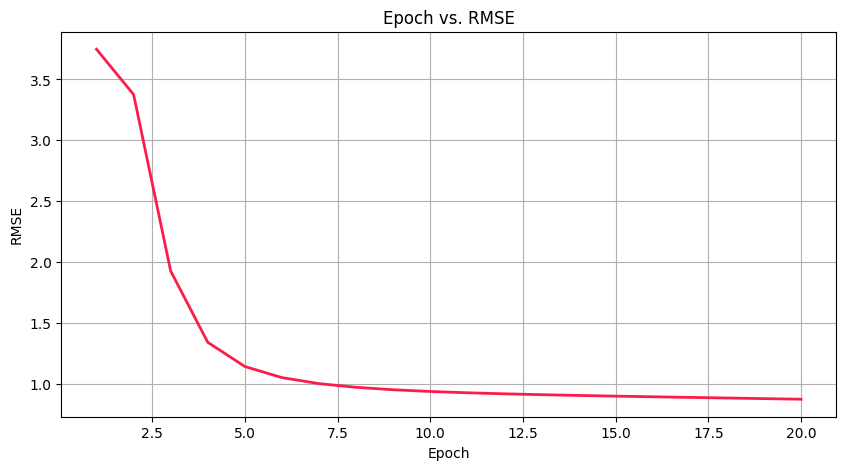

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), epoch_rmse, linewidth=2, color="#fc1c49")
plt.title("Epoch vs. RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()

In [20]:
predictions: list[float] = []
true_ratings: list[float] = []

for _, row in tqdm(test_data.iterrows(), total=test_data.shape[0]):
    user_id = int(row["user_id"])
    movie_id = int(row["movie_id"])
    true_rating = row["user_rating"]

    predicted_rating = predict_rating(user_id, movie_id)
    predictions.append(round(predicted_rating))
    true_ratings.append(true_rating)

100%|██████████| 40000/40000 [00:02<00:00, 14482.78it/s]


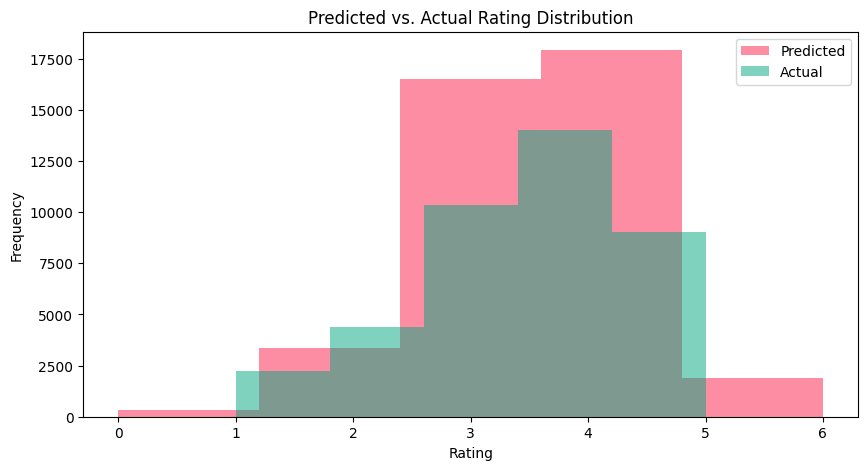

In [23]:
plt.figure(figsize=(10, 5))
plt.hist(predictions, bins=5, alpha=0.5, label="Predicted", color="#fc1c49")
plt.hist(true_ratings, bins=5, alpha=0.5, label="Actual", color="#00a67d")
plt.title("Predicted vs. Actual Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [24]:
rmse = np.sqrt(np.mean((np.array(predictions) - np.array(true_ratings))**2))
print(f"RMSE: {rmse}")

RMSE: 1.0064169116226138


# 3